In [18]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sstats
import scikit_posthocs as sp

In [19]:
gplt = plt.rcParams.update({'figure.facecolor': 'white'})
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

def loadCombine(csv_dirs):
    df_list = []
    for alg_name, path_pattern in csv_dirs.items():
        for filepath in glob.glob(path_pattern):
            df = pd.read_csv(filepath)
            df['algorithm'] = alg_name
            df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

csv_dirs = {
    'CMA_ES': 'CMA_ES_results_20250523_165219/CMA_ES_results.csv',
    'DE':     'DE_VarialbeDimensions_results_20250519_180533/DE_VariableDimensions_results.csv',
    'GA':     'GA_Variable_results_20250518_131037/GA_Variable_results.csv',
    'GE':     'GE_results_20250523_180336/GE_results.csv',
    'GP':     'GP_results_20250525_115347/GP_results.csv'
}
results = loadCombine(csv_dirs)

print(results.describe())
print(results.isna().sum())
results = results[np.isfinite(results['best'])]

target_map = {
    'Sphere':    30,
    'Rastrigin': 30,
    'Griewank':  30,
    'Ackley':    30,
    'Koza':      10,
    'Knapsack':  20,
    'Parity':    64,
    'SantaFe':   100
}
results['delta_len'] = results.apply(
    lambda r: abs(r['len_final'] - target_map[r['benchmark']]), axis=1
)

        replicate          seed        best   len_final        cpu_s
count  900.000000  9.000000e+02  900.000000  900.000000   900.000000
mean    14.500000  1.104048e+09  -55.251574   55.082222   242.840525
std      8.660254  6.197597e+08  171.689065   70.372787   678.046540
min      0.000000  1.175039e+07 -634.000000    3.000000     1.792800
25%      7.000000  5.594170e+08   -2.700000   28.000000     6.467750
50%     14.500000  1.124714e+09    0.002307   32.000000    19.023350
75%     22.000000  1.639542e+09    1.273324   66.000000   149.757100
max     29.000000  2.146720e+09   81.889108  850.000000  4554.949700
run_id       0
benchmark    0
replicate    0
seed         0
best         0
len_final    0
cpu_s        0
algorithm    0
dtype: int64


C:\Users\JV\AppData\Local\Temp\ipykernel_516\1632472185.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


                         best_q      best_q     best_q        best_q  \
benchmark algorithm                                                    
Ackley    CMA_ES       4.045829    0.000046  15.211899  7.500000e-07   
          DE           0.118297    0.068870   0.130313  3.695300e-02   
          GA           0.088260    0.082522   0.036155  6.383275e-02   
Griewank  CMA_ES       6.000417    0.000000  18.307694  0.000000e+00   
          DE           1.000579    0.000258   5.477674  1.307500e-04   
          GA           0.000671    0.000417   0.000572  1.895000e-04   
Knapsack  CMA_ES    -463.900000 -480.000000  54.962903 -5.110000e+02   
          DE        -634.000000 -634.000000   0.000000 -6.340000e+02   
          GA        -589.000000 -589.000000   0.000000 -5.890000e+02   
Koza      CMA_ES       6.446427    0.005371  19.464795  2.937000e-03   
          DE           4.819775    2.497370  10.097633  1.703801e+00   
          GA           0.042724    0.038476   0.029705  1.660725

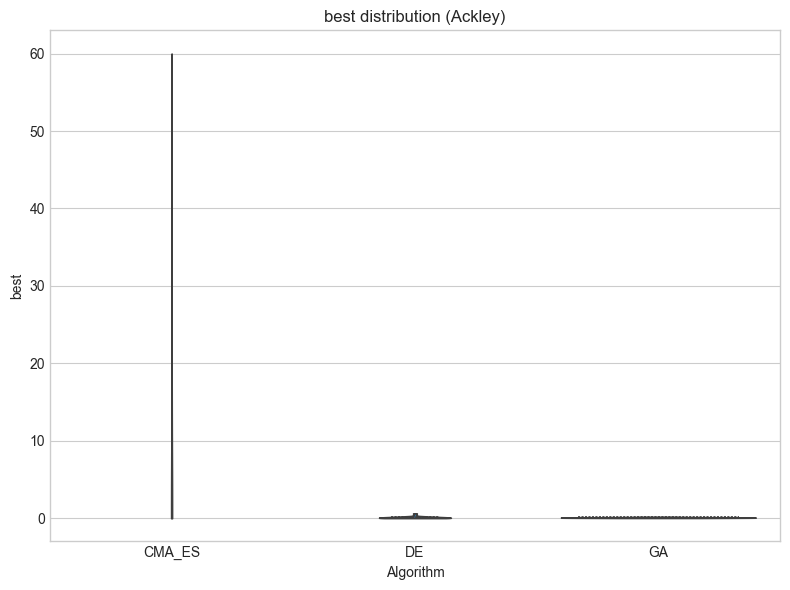

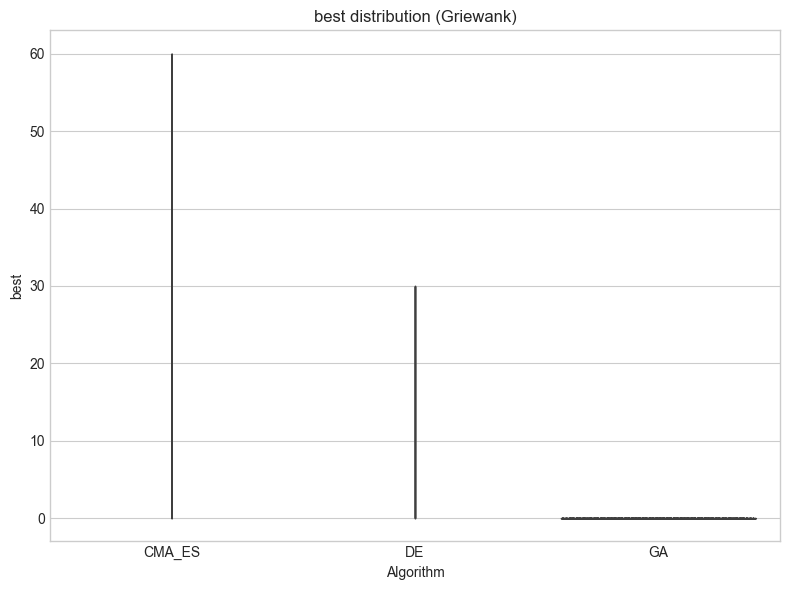

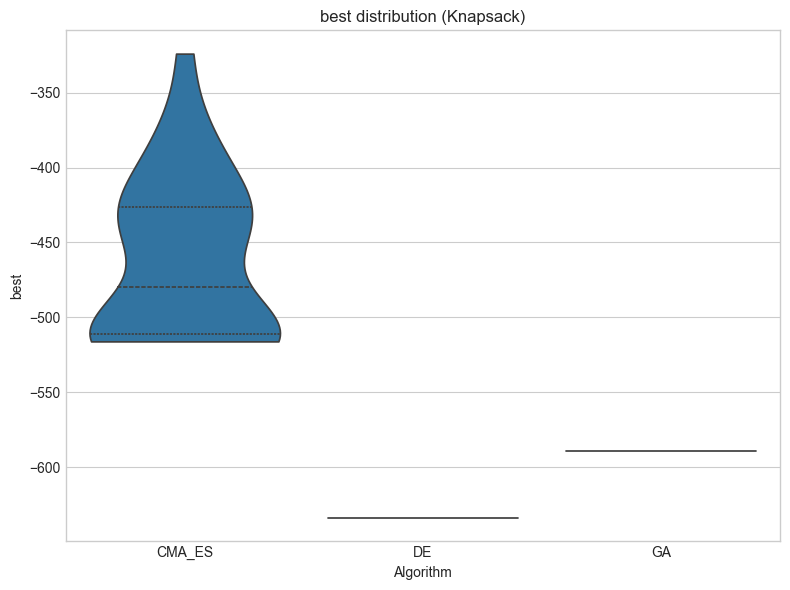

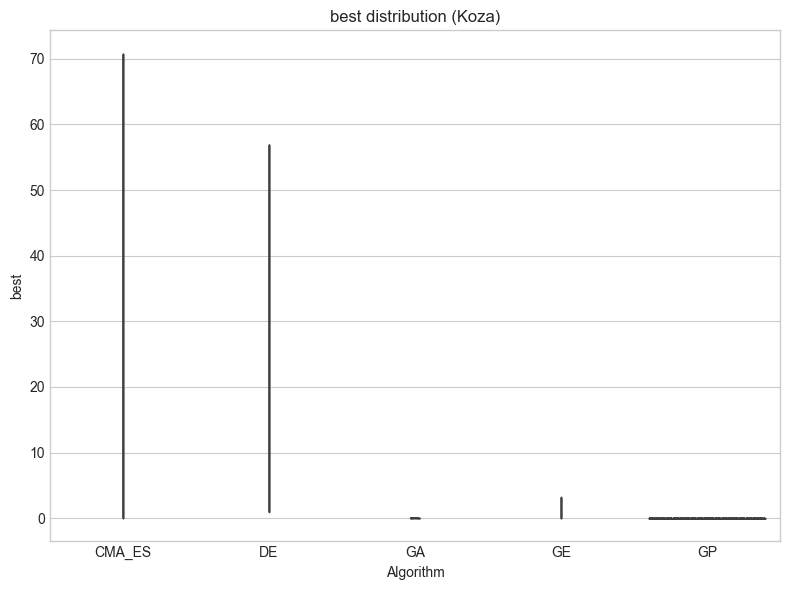

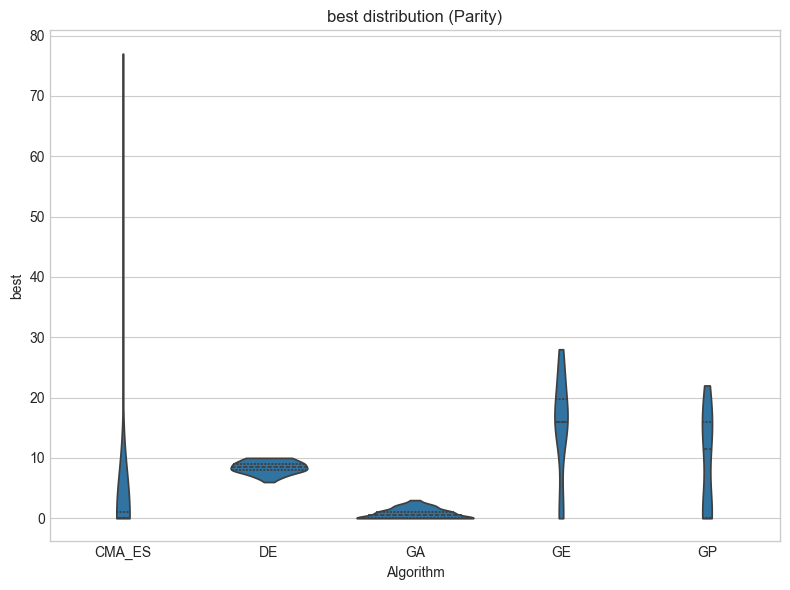

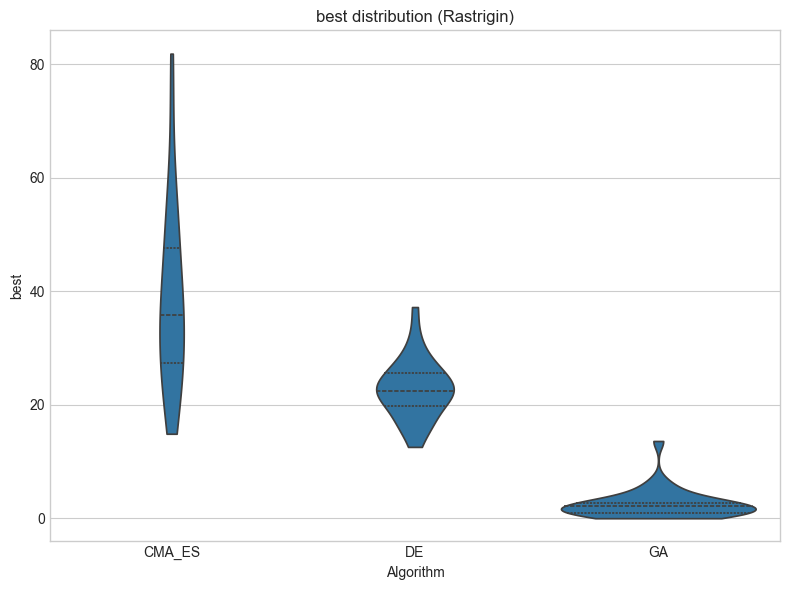

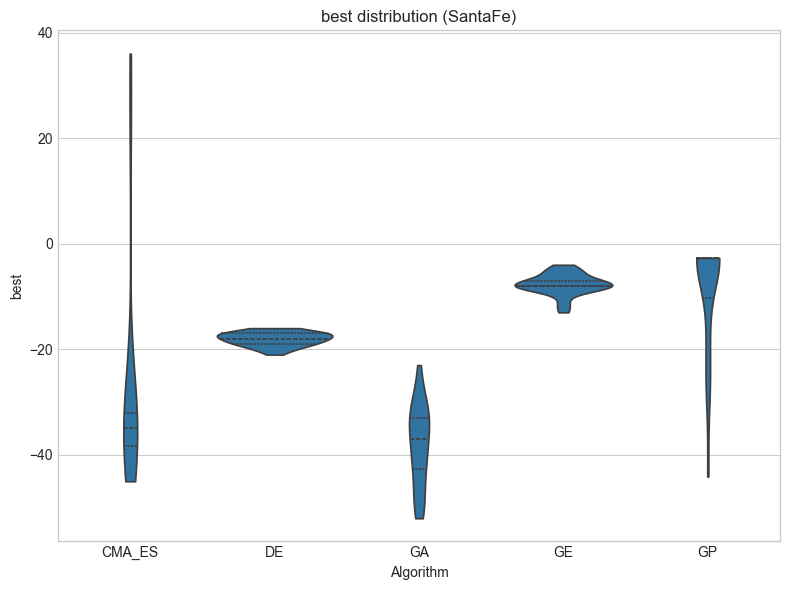

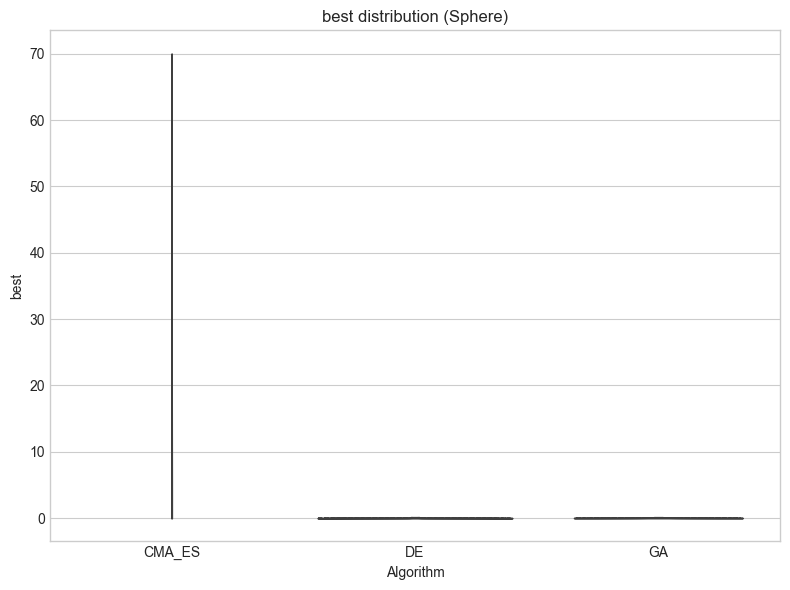

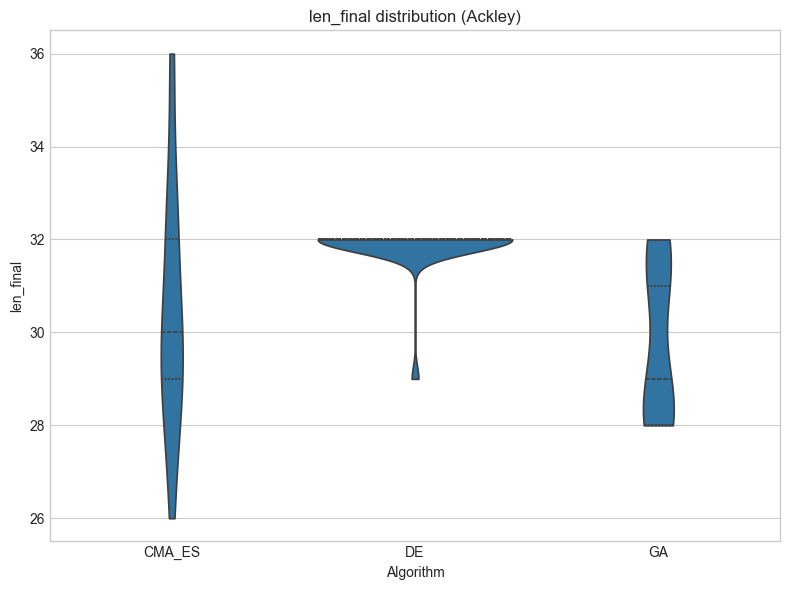

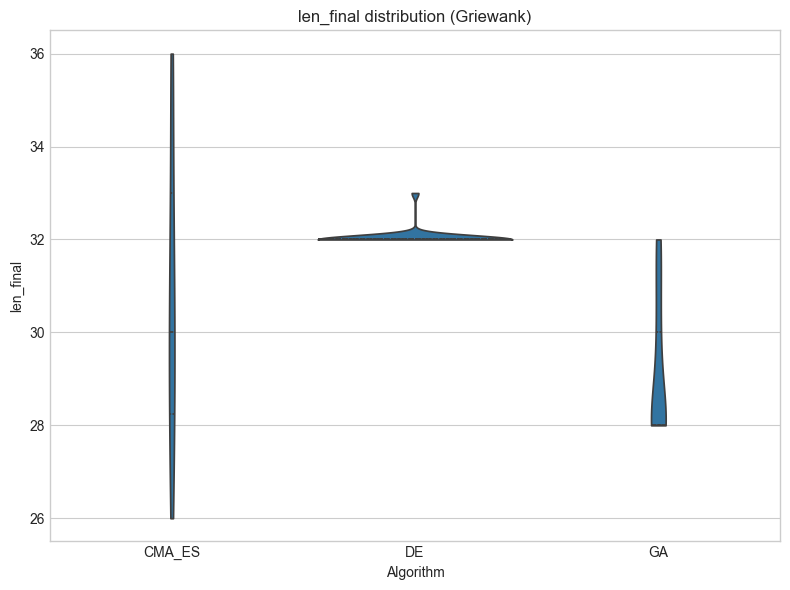

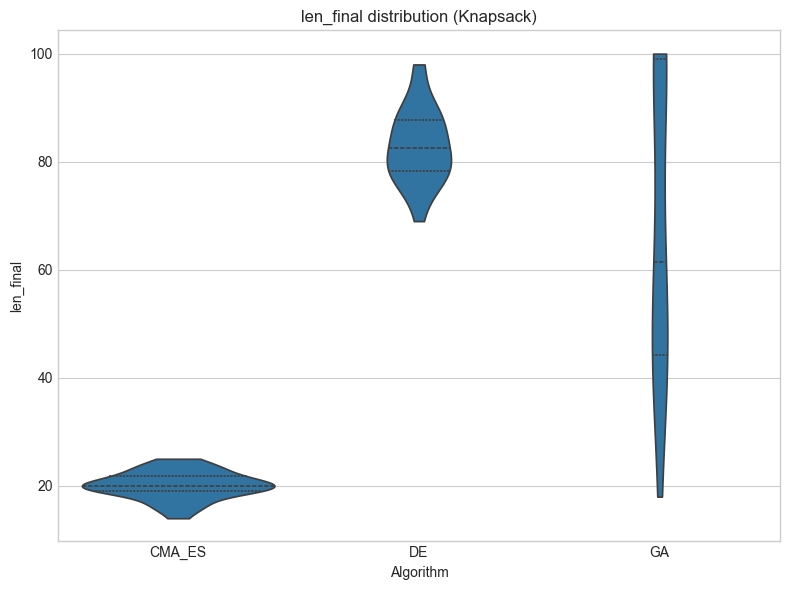

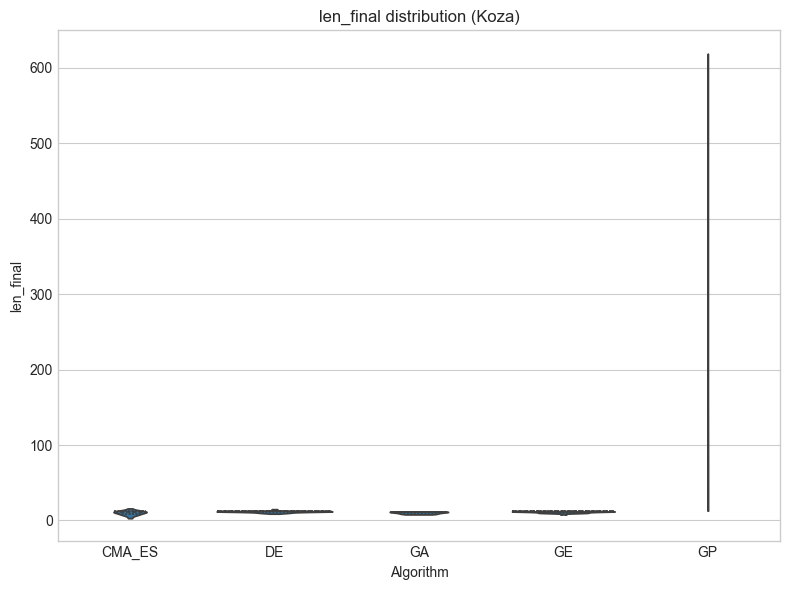

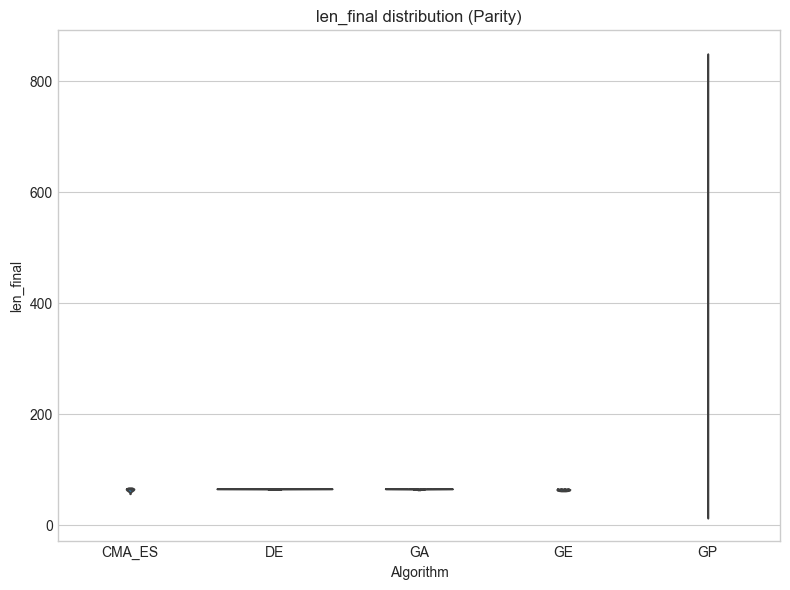

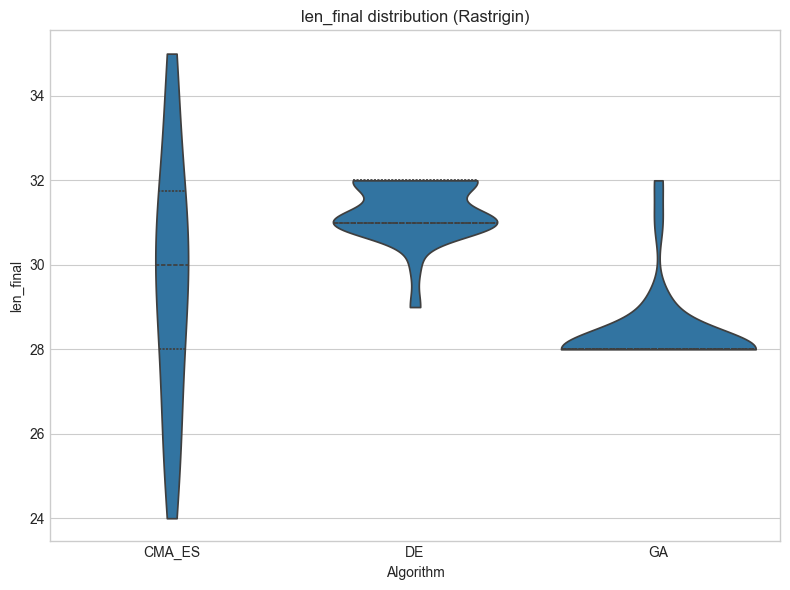

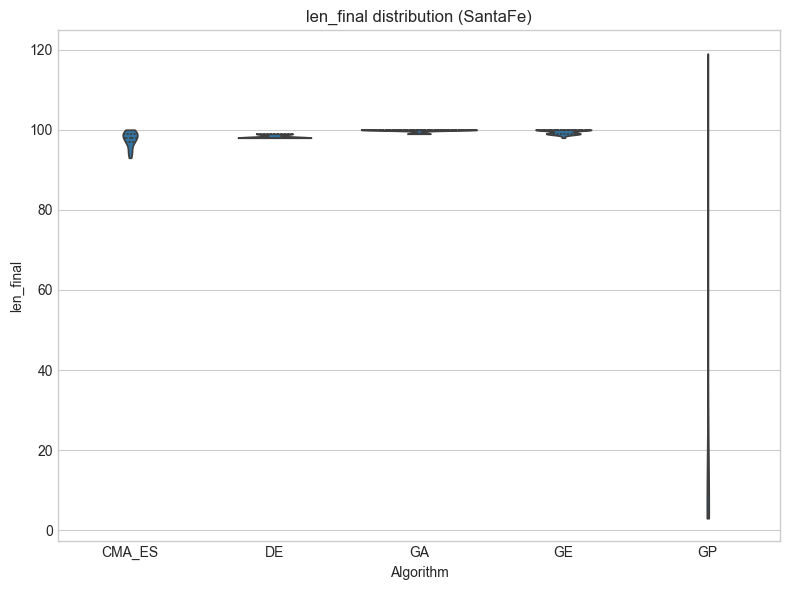

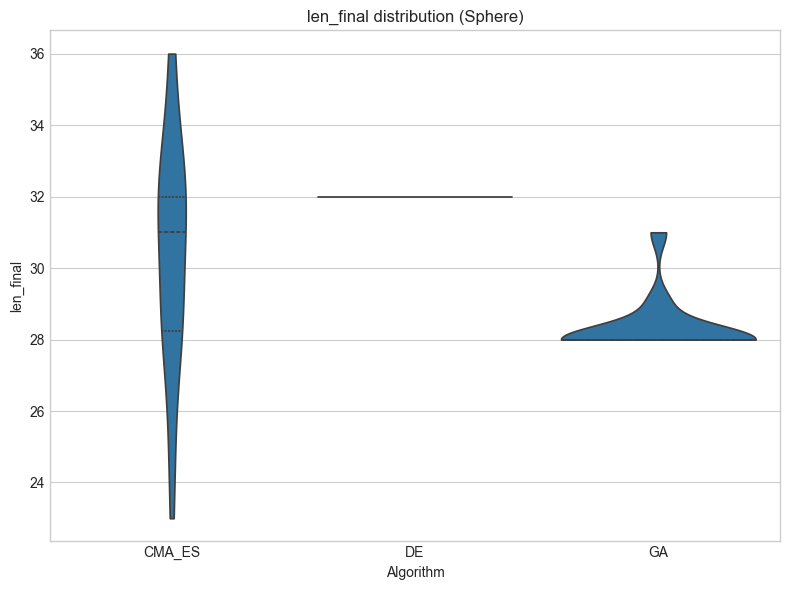

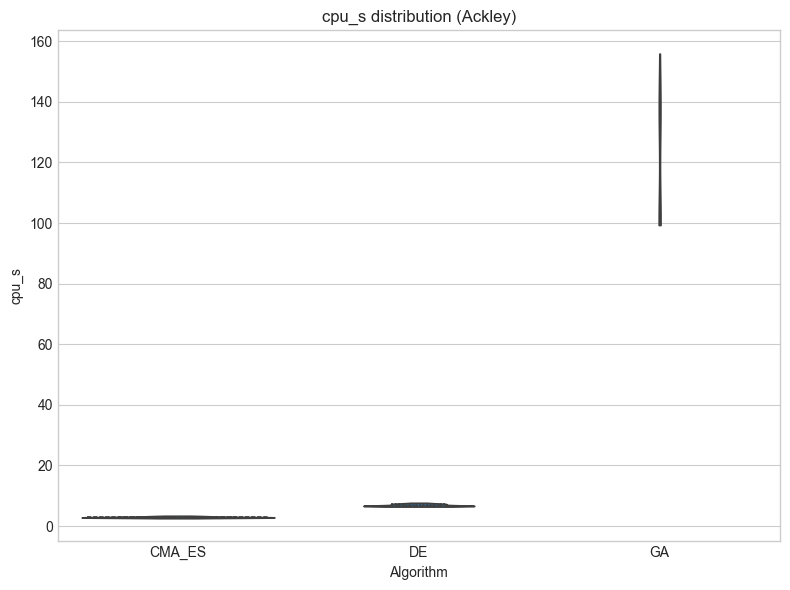

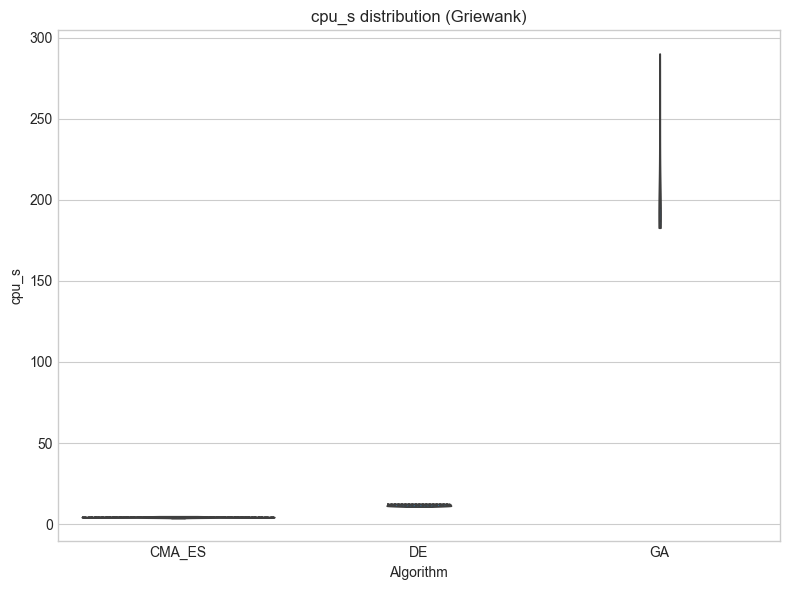

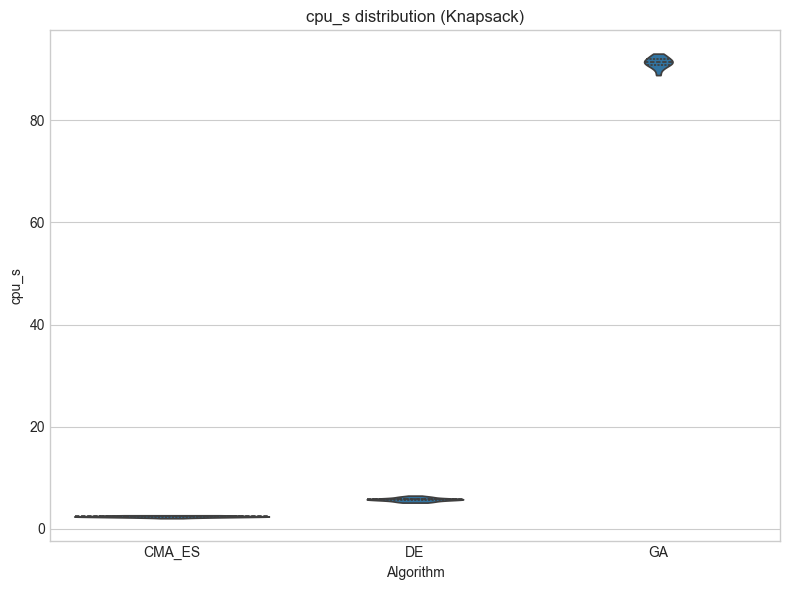

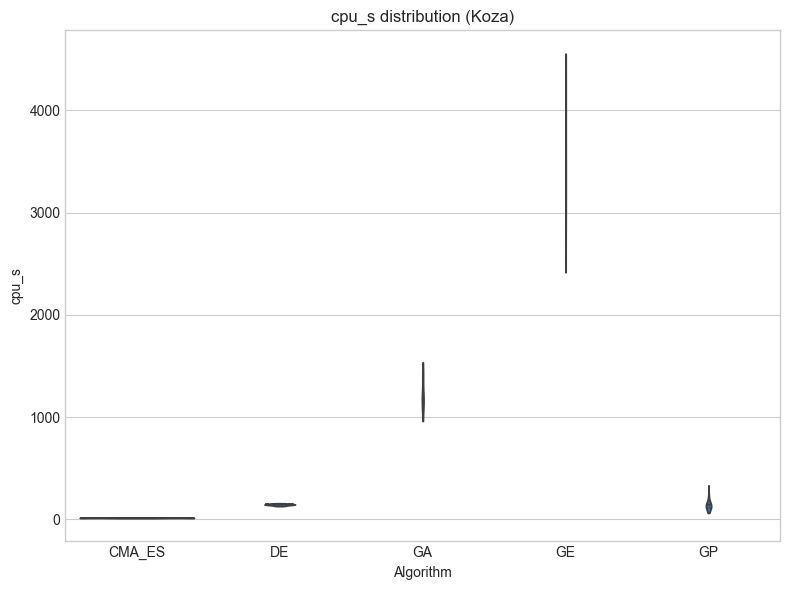

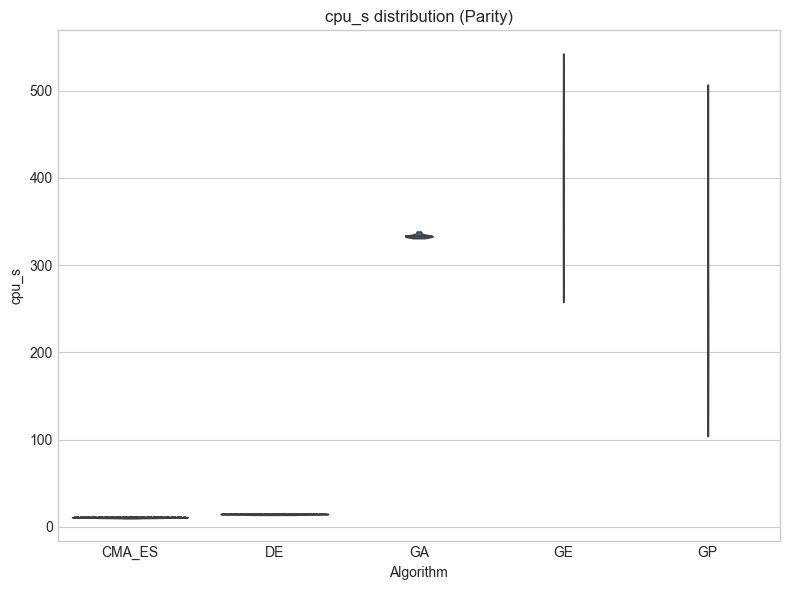

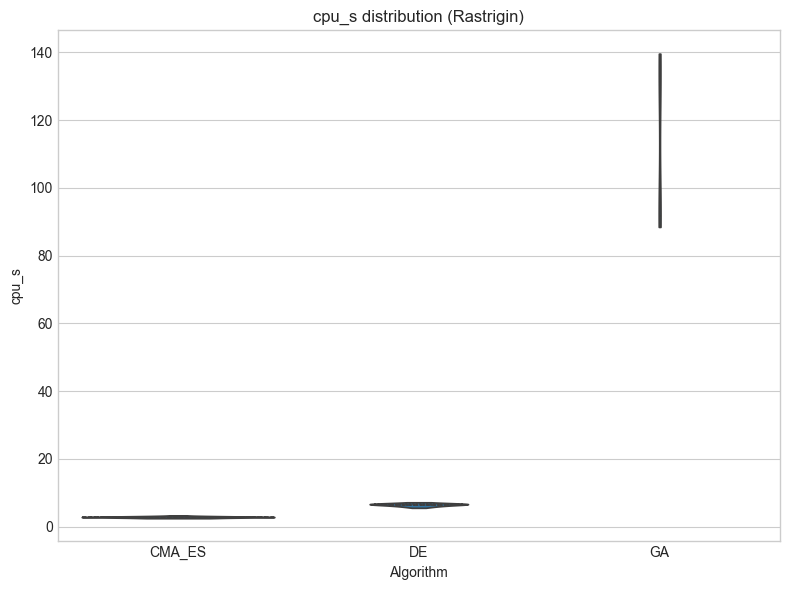

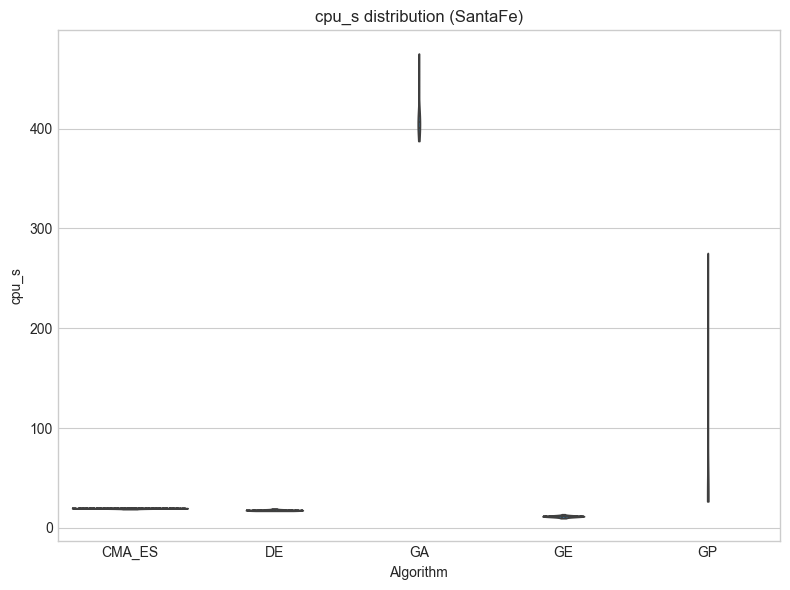

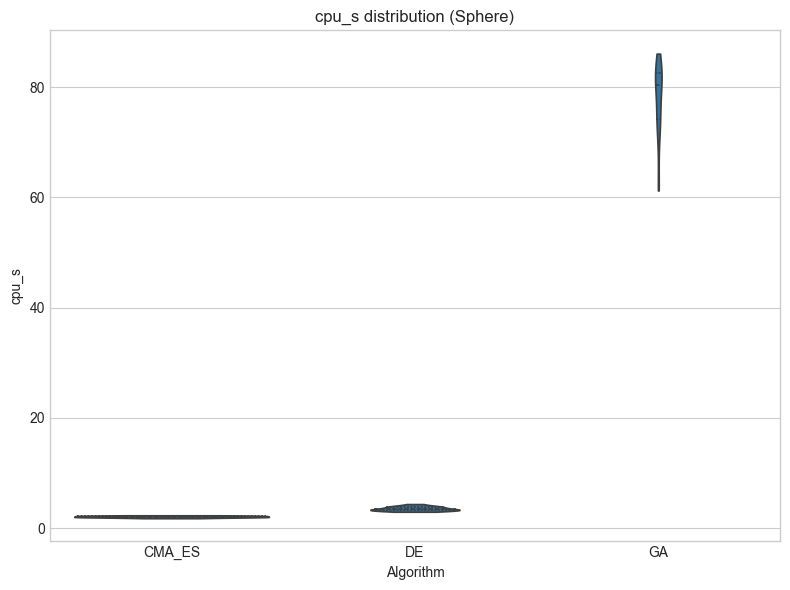

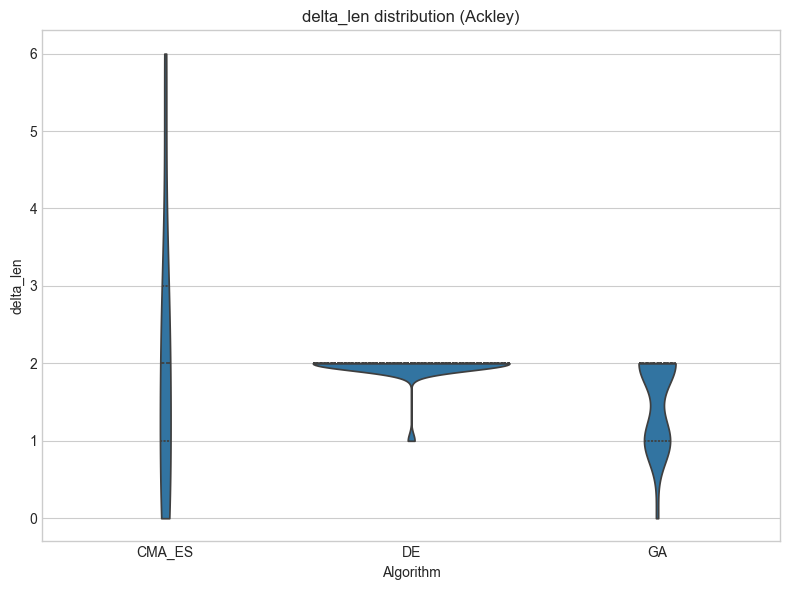

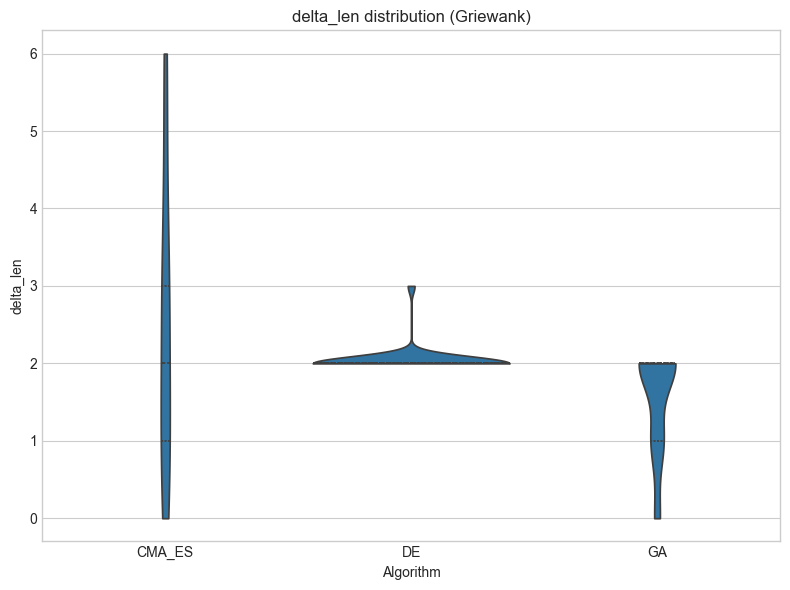

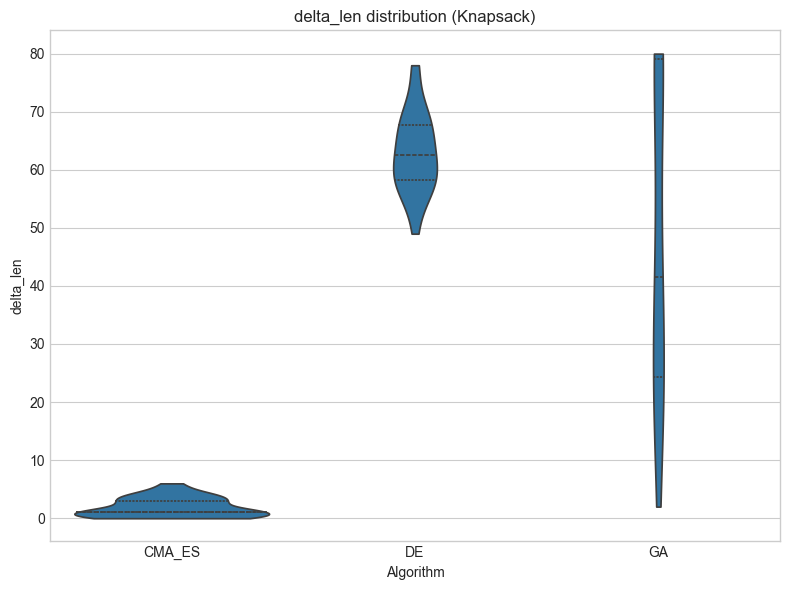

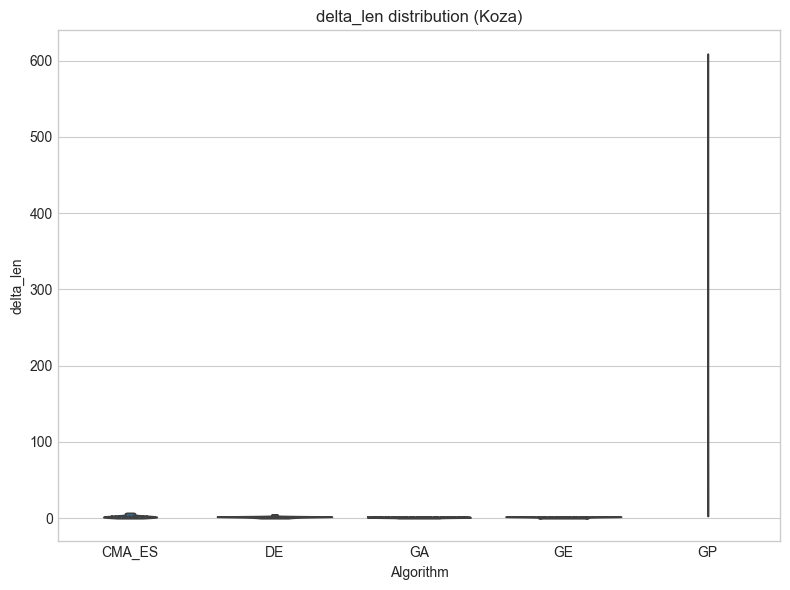

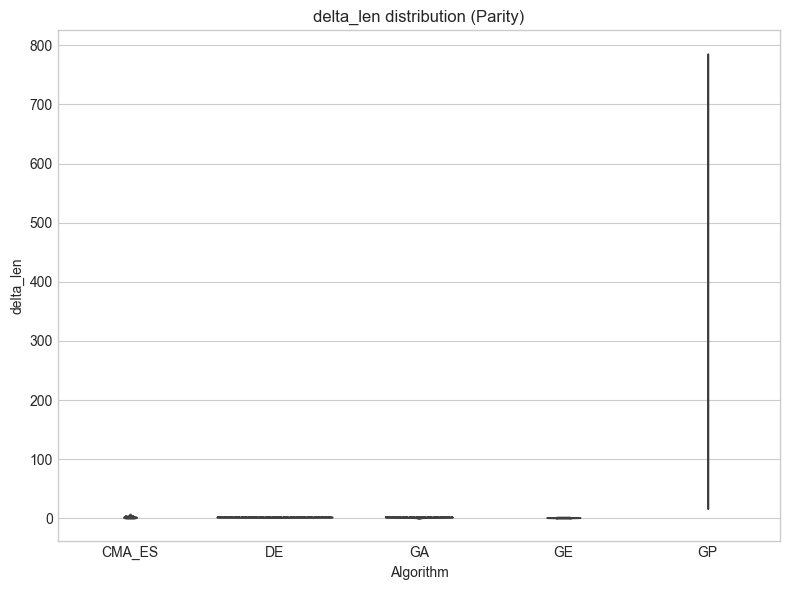

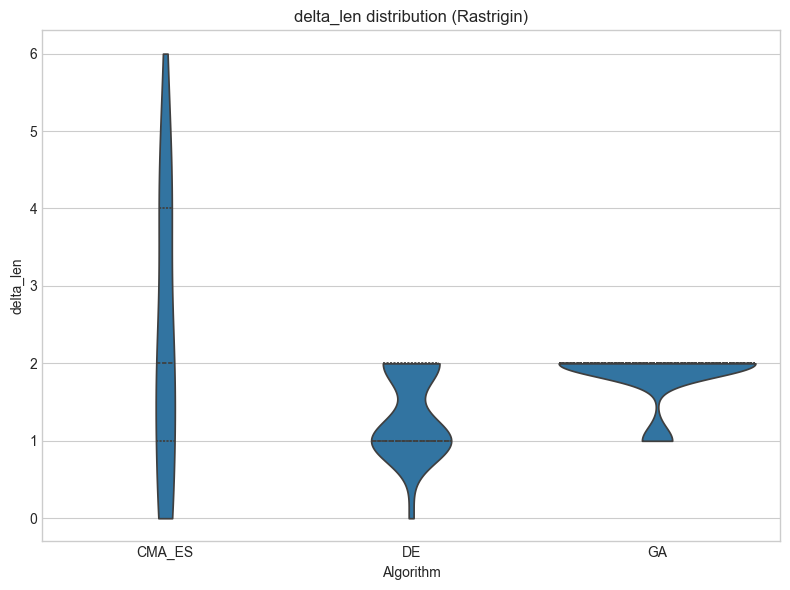

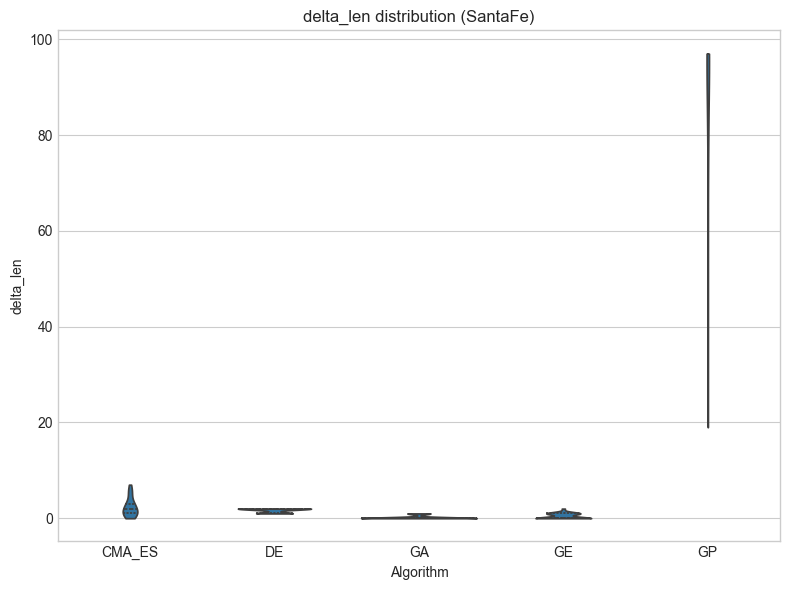

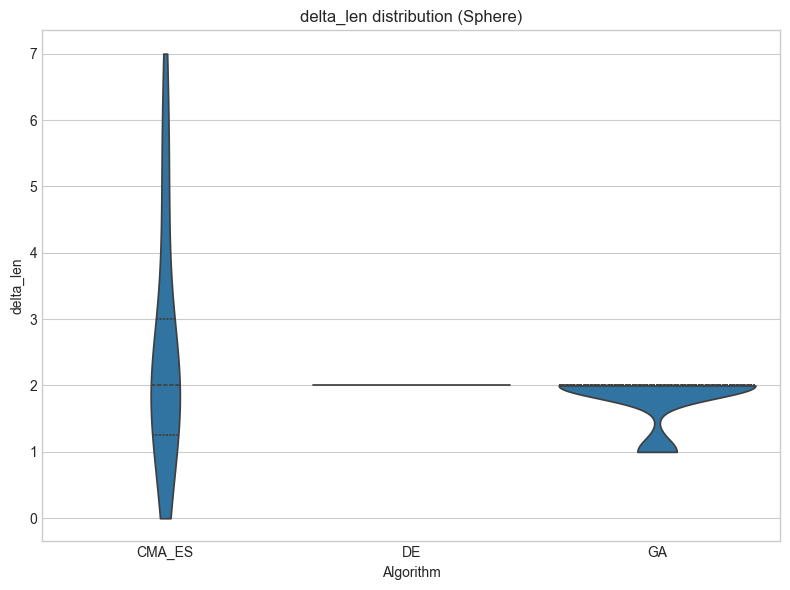

In [20]:
metrics = ['best','len_final','cpu_s','delta_len']
desc_stats = results.groupby(['benchmark','algorithm'])[metrics].agg([
    'mean','median','std',
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75)
])
desc_stats.columns = [f"{m}_{agg.__name__ if hasattr(agg,'__name__') else 'q'}"
                      for m, agg in desc_stats.columns]
print(desc_stats)

for m in metrics:
    for bench, sub in results.groupby('benchmark'):
        plt.figure(figsize=(8,6))
        sns.violinplot(x='algorithm', y=m, data=sub, inner='quartile', cut=0)
        plt.title(f'{m} distribution ({bench})')
        plt.xlabel('Algorithm')
        plt.ylabel(m)
        plt.tight_layout()
        plt.show()

In [21]:
def friedmanPosthoc(df, metric):
    print(f'--- Tests: {metric} ---')
    for bench, sub in df.groupby('benchmark'):
        data = [g[metric].values for _, g in sub.groupby('algorithm')]
        stat, p = sstats.friedmanchisquare(*data)
        print(f'{bench}: Friedman stat={stat:.3f}, p={p:.3e}')
        if p < 0.05:
            pivot = sub.pivot(index='replicate', columns='algorithm', values=metric)
            nemenyi = sp.posthoc_nemenyi_friedman(pivot)
            print(nemenyi)

for m in metrics:
    friedmanPosthoc(results, m)

--- Tests: best ---
Ackley: Friedman stat=29.067, p=4.878e-07
        CMA_ES        DE        GA
CMA_ES   1.000  0.001000  0.001000
DE       0.001  1.000000  0.848105
GA       0.001  0.848105  1.000000
Griewank: Friedman stat=18.467, p=9.773e-05
          CMA_ES        DE        GA
CMA_ES  1.000000  0.002277  0.001000
DE      0.002277  1.000000  0.774254
GA      0.001000  0.774254  1.000000
Knapsack: Friedman stat=60.000, p=9.358e-14
        CMA_ES     DE     GA
CMA_ES   1.000  0.001  0.001
DE       0.001  1.000  0.001
GA       0.001  0.001  1.000
Koza: Friedman stat=88.963, p=2.186e-18
          CMA_ES        DE        GA        GE        GP
CMA_ES  1.000000  0.001000  0.900000  0.016442  0.012629
DE      0.001000  1.000000  0.001000  0.084006  0.001000
GA      0.900000  0.001000  1.000000  0.084006  0.001624
GE      0.016442  0.084006  0.084006  1.000000  0.001000
GP      0.012629  0.001000  0.001624  0.001000  1.000000
Parity: Friedman stat=59.942, p=2.983e-12
        CMA_ES       D

In [22]:
# TODO: Convergence analysis